In [9]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [10]:
def search_files(folder_path, string, extension):
    files = []
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is a regular file, contains the desired string in its name, and has the .csv extension
        if os.path.isfile(file_path) and string in filename and filename.endswith(extension):
            file = os.path.join(folder_path,filename)
            files.append(file)
    return files

In [11]:
TS = [2, 8, 16, 64, 128, 512, 1024, 4096, 8192, 16384]
wdir = '/mnt/michael/gitrepos/dla-collagen/analysis/data_dat'
DF = {'fn':[], 'ts':[]}
for ts in TS:
    files = search_files(wdir, f'ts_{ts}_', '.dat')
    num_files = len(files)
    DF['fn'].extend(files)
    DF['ts'].extend(num_files * [ts])
DF = pd.DataFrame(DF)
DF.groupby('ts').count()

,fn
ts,
2,50
8,50
16,50
64,50
128,50
512,50
1024,50
4096,50
8192,50


In [12]:
def read_dat(fn):
    df = pd.read_csv(fn, sep=' ', header=None)
    df.columns = ['uid', 'id_part', 'x', 'y', 'z']
    df.drop(['uid', 'id_part'], axis=1, inplace=True)
    return df

In [13]:
# exclude files with less than 3000 rows
DF['df'] = DF['fn'].apply(read_dat) # type: ignore

In [14]:
DF['y_min'] = DF['df'].apply(lambda df: df['y'].min()) # type: ignore
DF['y_max'] = DF['df'].apply(lambda df: df['y'].max() + 17) # type: ignore

In [15]:
DF['y_range'] = DF['y_max'] - DF['y_min'] # type: ignore

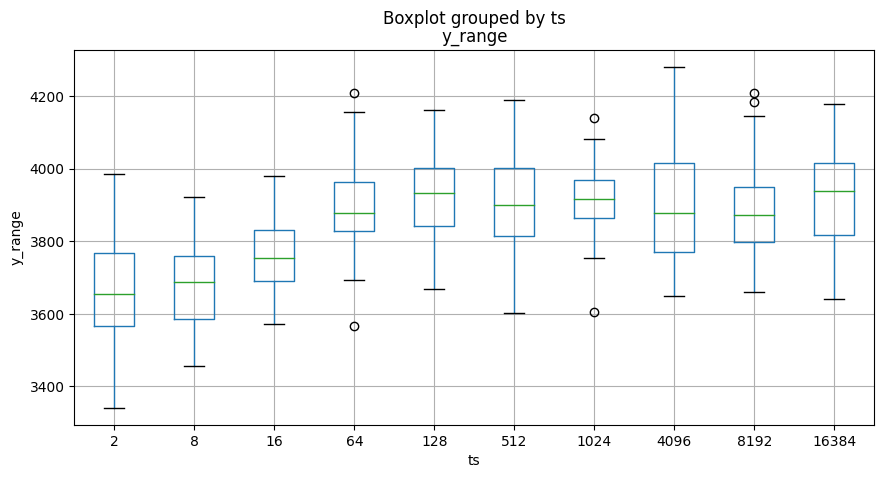

In [16]:
# plot a box plot, where the x-axis is the 'ts' col and the y-axis is the 'y_range' col
fig, ax = plt.subplots(figsize=(10, 5))
DF.boxplot(column='y_range', by='ts', ax=ax)
ax.set_xlabel('ts')
ax.set_ylabel('y_range')
plt.show()


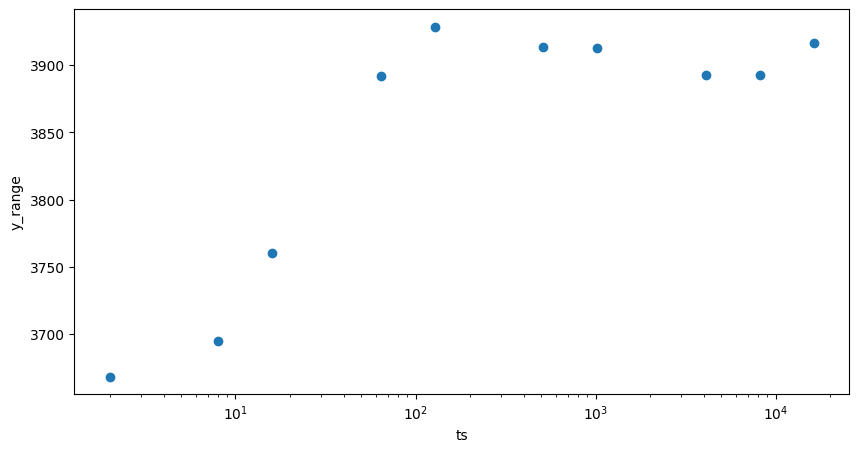

In [17]:
DF_MEAN = DF[['ts','y_range']].groupby('ts').mean() # type: ignore

# plot a scatter plot, where the x-axis is the 'ts' col and the y-axis is the 'y_range' col
# use log scale for the x-axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(DF_MEAN.index, DF_MEAN['y_range'])
ax.set_xlabel('ts')
ax.set_ylabel('y_range')
ax.set_xscale('log')
plt.show()


In [26]:
DF_F = {'ts':[], 'f':[], 'y':[]}
for ts in TS:
    DF_TS = DF[DF['ts'] == ts] # type: ignore
    y_val = []
    for df in DF_TS['df']: # type: ignore
        y_val.extend(df['y'].values)
    y_val, f = np.unique(y_val, return_counts=True) # type: ignore
    DF_F['ts'].extend(len(f) * [ts])
    DF_F['f'].extend(f)
    DF_F['y'].extend(y_val)
DF_F = pd.DataFrame(DF_F)
DF_F = DF_F.groupby(['ts','y']).mean().reset_index() # type: ignore

In [28]:
DF_F['ts_label'] = [f'{ts}' for ts in DF_F['ts']]
fig = px.scatter(DF_F, x='y', y='f', color='ts_label', width=1000, height=500)
fig.show()

In [7]:
df = DF['df'].iloc[0] # type: ignore
y_val = []
for y in df['y']:
    for i in range(18):
        y_val.append(y + i)

y_val, count = np.unique(y_val, return_counts=True)
df = {'y_val':y_val, 'count':count}
fig = px.scatter(df, x='y_val', y='count', width=1000, height=500)
fig.show()


In [153]:
def particles(fn, ts, cont):
    fd = 'ts_' + str(ts) + '_' + str(cont) + '.txt'
    with open (fd, "w") as fid:
        with open(fn) as fid2:
            id = 0  # Initialize the id variable outside the loop
            for row in fid2.readlines():
                if 'uid:' in row:
                    row = row.split()
                    id = int(row[1])
                    x = int(row[2])
                    y = int(row[3])
                    z = int(row[4])

                for i in range(0, 18):
                    fid.write('uid %d %d %d %d\n' % (id, x, y + i, z))



In [159]:
### Densidade por comprimento
TS = [2, 8, 16, 64, 128, 512, 1024, 4096, 8192, 16384]
y = np.linspace(0,10,10)
for ts in TS[:8]:
    wdir = '/home/robert/data_zurik/fibrilas_usadas/'  # Replace with the path to your folder
    string = 'ts_' + str(ts) +'_'
    #print(string)
    print('reading data for Ts = %d' %ts)
    extension = '.dat'
    files = search_files(wdir,string, extension)
    for j in range(len(files)):
        particles(files[j], ts, j)


reading data for Ts = 2
reading data for Ts = 8
reading data for Ts = 16
reading data for Ts = 64
reading data for Ts = 128
reading data for Ts = 512
reading data for Ts = 1024
reading data for Ts = 4096


In [124]:
files

['/home/robert/collagen_fibril/dla-collagen/python/ts_16384_0.txt',
 '/home/robert/collagen_fibril/dla-collagen/python/ts_16384_1.txt',
 '/home/robert/collagen_fibril/dla-collagen/python/ts_16384_3.txt',
 '/home/robert/collagen_fibril/dla-collagen/python/ts_16384_2.txt',
 '/home/robert/collagen_fibril/dla-collagen/python/ts_16384_4.txt']

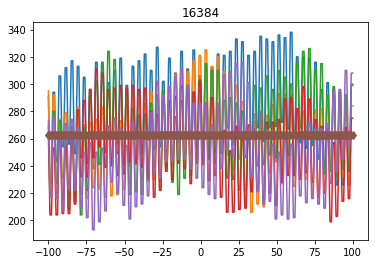

In [166]:
m = 0
for j in range(len(files)):
    df = pd.read_csv(files[j], delimiter=' ', names=['uid', 'id_part', 'x', 'y', 'z'])
    # Get unique values and their counts
    unique_values, counts = np.unique(df['y'], return_counts=True)

    # Filter values within the interval [-100, 100]
    filtered_indices = np.where((unique_values >= -100) & (unique_values <= 100))
    filtered_values = unique_values[filtered_indices]
    filtered_counts = counts[filtered_indices]

    # Create a new dataframe with counts
    df_counts = pd.DataFrame({'Value': filtered_values, 'Count': filtered_counts})
    md_df = df_counts['Count'].sum()/201
    m = m + md_df


    plt.plot(df_counts['Value'], df_counts['Count'])

y = np.linspace(-100,100,201)
y = np.ones(len(y)) * (m/5)

plt.title(ts)

plt.plot(y,y, '-d')
#plt.xlim(-100,100)

reading data for Ts = 2


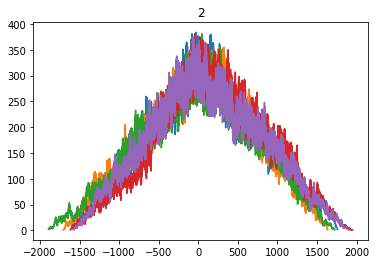

reading data for Ts = 8


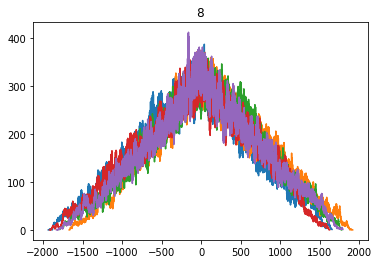

reading data for Ts = 16


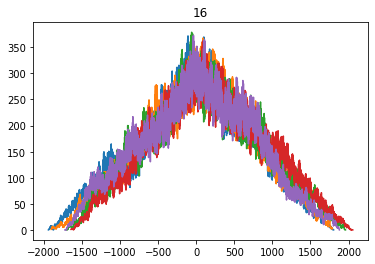

reading data for Ts = 64


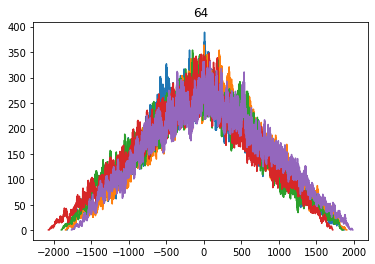

reading data for Ts = 128


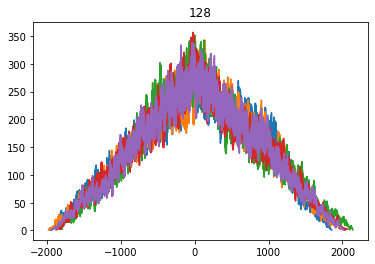

reading data for Ts = 512


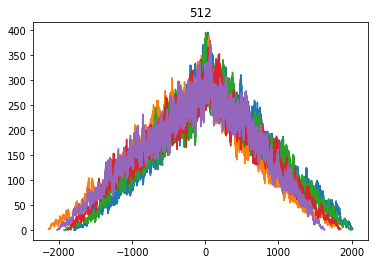

reading data for Ts = 1024


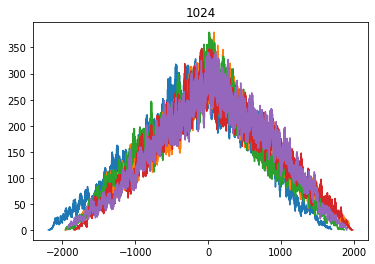

reading data for Ts = 4096


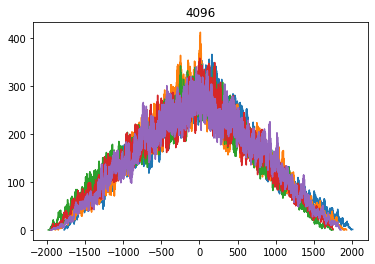

reading data for Ts = 8192


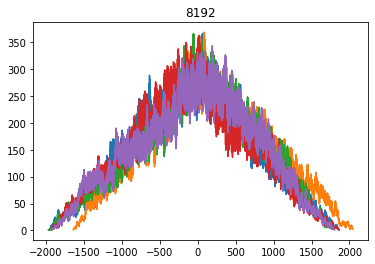

reading data for Ts = 16384


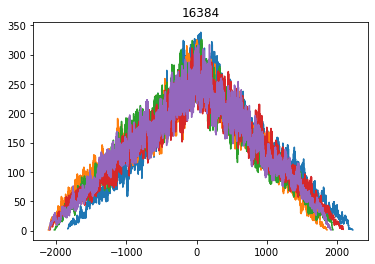

In [160]:
TS = [2, 8, 16, 64, 128, 512, 1024, 4096, 8192, 16384]
y = np.linspace(0,10,10)
for ts in TS[:]:
    wdir = '/home/robert/collagen_fibril/dla-collagen/python'  # Replace with the path to your folder
    string = 'ts_' + str(ts) +'_'
    #print(string)
    print('reading data for Ts = %d' %ts)
    extension = '.txt'
    files = search_files(wdir,string, extension)
    m = 0
    
    for j in range(len(files)):
        
        df = pd.read_csv(files[j], delimiter=' ', names=['uid', 'id_part', 'x', 'y', 'z'])
        # Get unique values and their counts
        unique_values, counts = np.unique(df['y'], return_counts=True)

        # Create a new dataframe with counts
        df_counts = pd.DataFrame({'Value': unique_values, 'Count': counts})
        md_df = df_counts['Count'].sum()/201
        m = m + md_df


        plt.plot(df_counts['Value'], df_counts['Count'])

    plt.title(ts)
    plt.show()
#plt.xlim(-100,100)
    

(-100.0, 100.0)

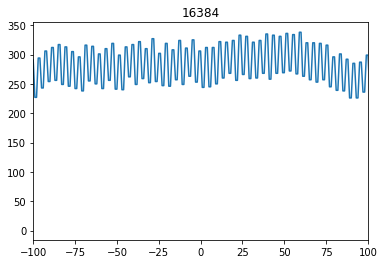

In [132]:
df_counts

plt.plot(df_counts['Value'], df_counts['Count'])
plt.title(ts)
plt.xlim(-100,100)

In [ ]:
file = files[0]
file_path = os.path.join(wdir, file)
df = pd.read_csv(file_path, names=['uid', 'id_part', 'x', 'y', 'z'])

xmin = df['x'].min()
xmax = df['x'].max()
ymin = df['y'].min()
ymax = df['y'].max()
zmin = df['z'].min()
zmax = df['z'].max()

l1 = xmax - xmin
l2 = zmax - zmin

l = ymax - ymin
A = l1 * l2

In [84]:
import pandas as pd
import os

TS = [2, 8, 16, 64, 128, 512, 1024, 4096, 8192, 16384]

for ts in TS:
    wdir = '/home/robert/data_zurik/fibrilas_usadas/'  # Substitua pelo caminho para a sua pasta
    string = 'ts_' + str(ts) + '_'
    extension = '.dat'
    files = search_files(wdir,string, extension)
    
    if len(files) == 0:
        continue
    
    l_values = []
    A_values = []
    
    print(len(files))
    for file in files:
        file_path = os.path.join(wdir, file)
        df = pd.read_csv(file_path, names=['uid', 'id_part', 'x', 'y', 'z'])
        
        xmin = df['x'].min()
        xmax = df['x'].max()
        ymin = df['y'].min()
        ymax = df['y'].max()
        zmin = df['z'].min()
        zmax = df['z'].max()
        
        l1 = xmax - xmin
        l2 = zmax - zmin
        
        l = ymax - ymin
        A = l1 * l2
        
        l_values.append(l)
        A_values.append(A)
    
    l_mean = sum(l_values) / len(l_values)
    A_mean = sum(A_values) / len(A_values)
    
    print("For Ts = %d" % ts)
    print("Average l: %f" % l_mean)
    print("Average A: %f" % A_mean)
    print()


5
For Ts = 2
Average l: nan
Average A: nan

5
For Ts = 8
Average l: nan
Average A: nan

5
For Ts = 16
Average l: nan
Average A: nan

5
For Ts = 64
Average l: nan
Average A: nan

5
For Ts = 128
Average l: nan
Average A: nan

5
For Ts = 512
Average l: nan
Average A: nan

5
For Ts = 1024
Average l: nan
Average A: nan

5
For Ts = 4096
Average l: nan
Average A: nan

5
For Ts = 8192
Average l: nan
Average A: nan

5
For Ts = 16384
Average l: nan
Average A: nan



In [79]:
At

[[992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992],
 [992, 992, 992, 992, 992]]

In [59]:
for ts in TS[:]:
    wdir = '/home/robert/data_zurik/fibrilas_usadas/'  # Replace with the path to your folder
    string = 'ts_' + str(ts) +'_'
    #print(string)
    print('reading data for Ts = %d' %ts)
    extension = '.dat'
    files = search_files(wdir,string, extension)
    A0 = []
    l0 = []
    for j in files:
        print(j)
        data = pd.read_csv(j, header=None, delimiter='\s+')
        # Set column names for reference
        df.columns = ['id_rod', 'id_part', 'x', 'y', 'z']
        #display(df)
        # Extract the desired columns
        column2_values = df['x']
        column4_values = df['z']
        column3_values = df['y']

        # Calculate the minimum and maximum values
        column2_min = column2_values.min()
        column2_max = column2_values.max()
        column3_min = column3_values.min()
        column3_max = column3_values.max()
        column4_min = column4_values.min()
        column4_max = column4_values.max()

        # Print the results
        #print("x - Min:", column2_min)
        #print("x - Max:", column2_max)
        #print("y - Min:", column3_min)
        #print("y - Max:", column3_max)
        #print("z - Min:", column4_min)
        #print("z - Max:", column4_max)

        l1 = column4_max - column4_min
        l2 = column2_max - column2_min
        A0.append(l1*l2)
        l0.append(column3_max - column3_min)
        print(l1*l2)
        #print('min box %d: %d' % (ts[0], A))
        #print('lenght: %d' %lenght)
    
    print('data fiber ts: %d' %ts)
    print('mediun area: %d' %(sum(A0)/len(A0)))
    print('mediun length: %d' %(sum(l0)/len(l0)))
    print('########################################################3')

                

reading data for Ts = 2
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_2_nb_30000_seed_490_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_2_nb_30000_seed_715_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_2_nb_30000_seed_445_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_2_nb_30000_seed_460_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_2_nb_30000_seed_325_.dat
4725
data fiber ts: 2
mediun area: 4725
mediun length: 3324
########################################################3
reading data for Ts = 8
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_8_nb_30000_seed_1030_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_8_nb_30000_seed_1285_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_8_nb_30000_seed_880_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_8_nb_30000_seed_1435_.dat
4725
/home/robert/data_zurik/fibrilas_usadas/dla_mode_s_ts_8_nb_30000_seed_1390_.dat
